Excellent — now we’re in the **insight design phase** 🔍

You’ve got exactly the right mindset: before we start plotting, we should ask *“what stories and insights can these datasets reveal?”*

Let’s unpack this — category by category — and I’ll show you **what kind of analyses, indicators, and dashboard visuals** you can build from them.

---

## 🛢️ **1️⃣ PRICES — WTI & Brent**

**Data:**

* Daily prices from yfinance (`CL=F`, `BZ=F`)

**What we can find:**

* 🧭 **Price trends & cycles:** Identify bull/bear markets, volatility spikes
* ⚖️ **Brent–WTI spread:**

  * Indicates U.S. infrastructure constraints (pipeline capacity, storage)
  * Useful for tracking **regional arbitrage** opportunities
* 📉 **Returns & volatility:**

  * Compute rolling volatility, returns, correlation
  * Good for risk/hedging insights

**Visuals for dashboard:**

* Dual-line time series (WTI vs Brent)
* Spread chart (`Brent - WTI`)
* Volatility overlay

---

## ⚙️ **2️⃣ SUPPLY SIDE — Production**

**Data:**

* U.S., OPEC, World, Non-OPEC production (monthly)

**What we can find:**

* 📈 **Production trends:**

  * U.S. shale rebounds after COVID
  * OPEC+ output adjustments
* 🌍 **OPEC vs Non-OPEC share:**

  * Who drives global supply growth?
* ⚒️ **Impact of events:**

  * E.g., Russia sanctions, OPEC cuts, etc.

**Visuals:**

* Multi-line production trends
* Area chart: OPEC vs Non-OPEC vs U.S.
* Pie chart of production share by region

---

## ⛽ **3️⃣ DEMAND SIDE — Consumption**

**Data:**

* U.S. and world petroleum consumption

**What we can find:**

* 🔥 **Demand growth patterns:**

  * Economic expansion/recession cycles
* ⚡ **Elasticity:**

  * Compare consumption growth vs price movements
* 🌱 **Post-COVID recovery** or energy transition signals

**Visuals:**

* Line chart: global demand vs production
* Price vs demand scatter plot
* YoY growth rate chart

---

## 🚢 **4️⃣ TRADE — Imports & Exports**

**Data:**

* U.S. total imports, total exports, imports by country

**What we can find:**

* 🌍 **Trade balance:**

  * When did the U.S. become a net exporter?
* 🏭 **Import sources:**

  * Canada dominance, reduced OPEC dependency
* 🛳️ **Geopolitical exposure:**

  * Dependence on Middle East vs Western Hemisphere

**Visuals:**

* Net imports chart (imports – exports)
* Imports by country (stacked bar)
* Map view of trade flows 🌍

---

## 🛢️ **5️⃣ INVENTORIES — Stocks**

**Data:**

* U.S. commercial crude oil inventories
* OECD petroleum stocks

**What we can find:**

* 🧭 **Market tightness indicator:**

  * Falling inventories → bullish pressure
  * Rising inventories → oversupply
* 🔁 **Correlation with prices:**

  * Plot inventories vs WTI to see lag relationship

**Visuals:**

* Inventory level chart
* Overlay of WTI vs inventories
* 4-week moving average indicator

---

## ⚖️ **6️⃣ BALANCE & DERIVED VARIABLES**

**Derived Data:**

* World balance = Production – Consumption
* U.S. Net imports = Imports – Exports

**What we can find:**

* ⚖️ **Global market equilibrium:**

  * Deficits → price rally
  * Surpluses → price pressure
* 🔄 **OPEC’s balancing role:**

  * Adjusting cuts to match demand shifts

**Visuals:**

* “Market Balance” line chart
* Combined chart: price vs balance
* Colored surplus/deficit shading

---

## 🧠 **7️⃣ Example Insights (Dashboard Goals)**

| Theme   | Example Insight                                                      |
| ------- | -------------------------------------------------------------------- |
| Price   | Brent–WTI spread widened post-2021, reflecting infrastructure limits |
| Supply  | U.S. regained top producer spot post-COVID                           |
| Demand  | Consumption lagged production during 2020 lockdowns                  |
| Trade   | U.S. became net crude exporter in late 2019                          |
| Stocks  | Inventories fell sharply during 2022 supply shock                    |
| Balance | Global deficit explains the 2022 price rally                         |

---

## 💡 **Summary Dashboard Tabs (Possible Design)**

1. **Prices** — WTI, Brent, spreads, volatility
2. **Production** — US, OPEC, non-OPEC
3. **Demand** — US + global consumption
4. **Trade** — Imports/exports + balance
5. **Stocks** — Inventories vs price
6. **Balance** — Global supply–demand gap

---

Would you like me to help you **draft the data model / fetch structure** next (i.e., one Python script that pulls and stores all this data into DataFrames or CSVs),
or jump right into **Streamlit layout design** for these dashboard tabs?


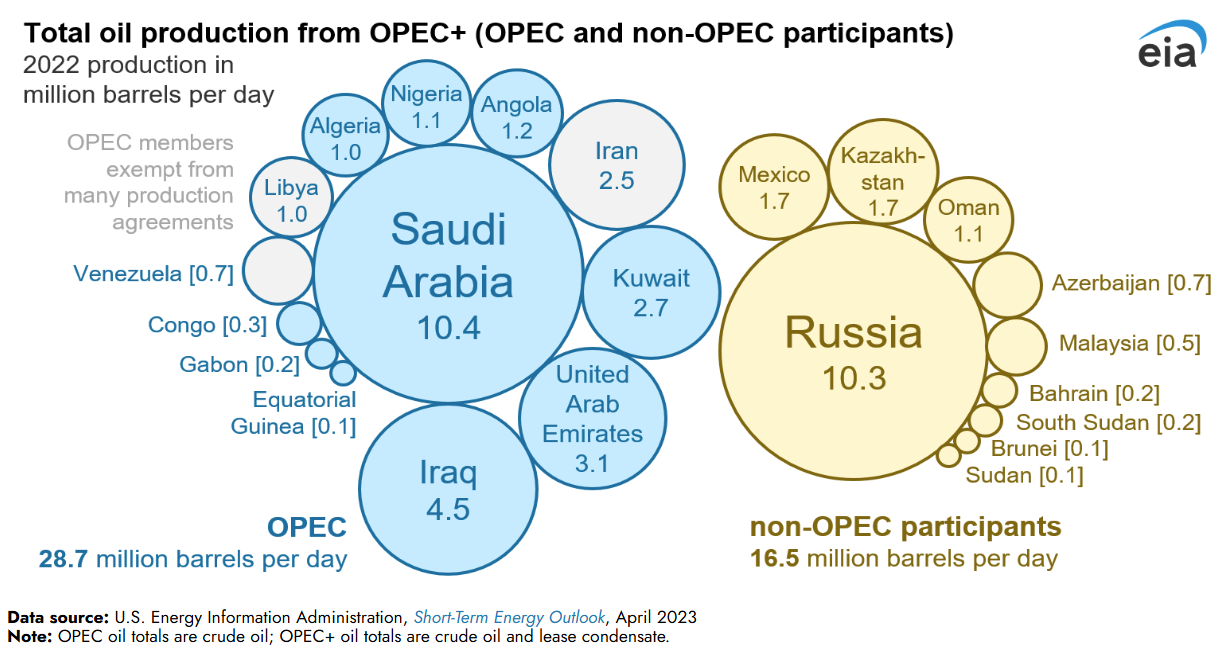

In [146]:
# fetch_prices.py
import os
import requests
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
EIA_API_KEY = os.getenv("EIA_API_KEY")

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
CSV_PATH = os.path.join(DATA_DIR, "prices.csv")

EIA_URL = "https://api.eia.gov/v2/petroleum/pri/spt/data/"
FREQUENCY = "daily"
START_DATE = "2015-01-01"
LENGTH = 5000

def fetch_prices():
    all_data = []
    offset = 0

    while True:
        params = {
            "api_key": EIA_API_KEY,
            "frequency": FREQUENCY,
            "data[0]": "value",
            "sort[0][column]": "period",
            "sort[0][direction]": "desc",
            "offset": offset,
            "length": LENGTH,
            "start": START_DATE,
        }

        response = requests.get(EIA_URL, params=params)
        response.raise_for_status()
        json_data = response.json()

        data = json_data.get("response", {}).get("data", [])
        if not data:
            break

        all_data.extend(data)

        if len(data) < LENGTH:
            break
        offset += LENGTH
        print(f"Fetched {len(all_data)} rows so far...")

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No data retrieved!")
        return df

    # Keep relevant columns
    df = df[["period", "product","product-name","process-name","series-description", "value", "units"]]

    # Clean types
    df["period"] = pd.to_datetime(df["period"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    df = df.sort_values(["period", "product"]).reset_index(drop=True)
    df = df[df.units == "$/BBL"]
    df.to_csv(CSV_PATH, index=False)
    print(f"Saved {len(df)} rows to {CSV_PATH}")
    return df

if __name__ == "__main__":
    fetch_prices()


HTTPError: 500 Server Error: Internal Server Error for url: https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=vxL1eP4u4cKRBQ4PkanKxxBs791wndEQzjxm8lwQ&frequency=daily&data%5B0%5D=value&sort%5B0%5D%5Bcolumn%5D=period&sort%5B0%5D%5Bdirection%5D=desc&offset=0&length=5000&start=2015-01-01

In [150]:
# fetch_prices.py
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime

# Load API key from .env
load_dotenv()
EIA_API_KEY = os.getenv("EIA_API_KEY")

# Output folder
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
CSV_PATH = os.path.join(DATA_DIR, "prices.csv")

# Parameters
PRODUCT_NAMES = {
    "WTI Crude Oil": "RWTC",   # WTI Cushing
    "UK Brent Crude Oil": "RBRTE"  # Europe Brent
}
FREQUENCY = "daily"  # daily prices
START_DATE = "2015-01-01"  # adjust as needed
LENGTH = 5000  # max rows per call

EIA_URL = "https://api.eia.gov/v2/petroleum/pri/spt/data/"

def fetch_prices():
    all_data = []
    offset = 0

    while True:
        params = {
            "api_key": EIA_API_KEY,
            "frequency": FREQUENCY,
            "data[0]": "value",
            "sort[0][column]": "period",
            "sort[0][direction]": "desc",
            "offset": offset,
            "length": LENGTH,
        }

        # Add facets for products
        for i, p in enumerate(PRODUCT_NAMES):
            params[f"facets[product][{i}]"] = p

        # Start date
        params["start"] = START_DATE

        response = requests.get(EIA_URL, params=params)
        response.raise_for_status()
        data = response.json()["response"]["data"]

        if not data:
            break

        for row in data:
            row["product-name"] = PRODUCT_NAMES.get(row["product"], row["product"])
        all_data.extend(data)

        if len(data) < LENGTH:
            break
        offset += LENGTH

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    if df.empty:
        print("No data retrieved!")
        return df

    # Keep relevant columns
    df = df[["period", "product","product-name","process-name","series-description", "value", "units"]]

    # Clean types
    df["period"] = pd.to_datetime(df["period"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Sort by period
    df = df.sort_values(["period","product"]).reset_index(drop=True)

    # Save CSV
    df.to_csv(CSV_PATH, index=False)
    print(f"Prices data saved to {CSV_PATH}, total rows: {len(df)}")
    return df

if __name__ == "__main__":
    fetch_prices()


No data retrieved!


In [151]:
prices = pd.read_csv("data/prices.csv", parse_dates=["period"])
prices

,period,product,product-name,process-name,series-description,value,units
0,2015-01-02,EPCBRENT,UK Brent Crude Oil,Spot Price FOB,Europe Brent Spot Price FOB (Dollars per Barrel),55.38,$/BBL
1,2015-01-02,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",52.72,$/BBL
2,2015-01-05,EPCBRENT,UK Brent Crude Oil,Spot Price FOB,Europe Brent Spot Price FOB (Dollars per Barrel),51.08,$/BBL
3,2015-01-05,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",50.05,$/BBL
4,2015-01-06,EPCBRENT,UK Brent Crude Oil,Spot Price FOB,Europe Brent Spot Price FOB (Dollars per Barrel),50.12,$/BBL
...,...,...,...,...,...,...,...
5453,2025-10-16,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",58.29,$/BBL
5454,2025-10-17,EPCBRENT,UK Brent Crude Oil,Spot Price FOB,Europe Brent Spot Price FOB (Dollars per Barrel),61.23,$/BBL
5455,2025-10-17,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",58.30,$/BBL
5456,2025-10-20,EPCBRENT,UK Brent Crude Oil,Spot Price FOB,Europe Brent Spot Price FOB (Dollars per Barrel),60.71,$/BBL


In [163]:
prices['period'] = pd.to_datetime(prices['period'])
df = prices.copy()
df = df.set_index('period').sort_index()
df_wti = df[df['product-name'] == 'WTI Crude Oil']
df_weekly = df_wti.resample('W-FRI').last().reset_index()

In [165]:
df_weekly

,period,product,product-name,process-name,series-description,value,units
0,2015-01-02,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",52.72,$/BBL
1,2015-01-09,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",48.35,$/BBL
2,2015-01-16,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",48.49,$/BBL
3,2015-01-23,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",45.26,$/BBL
4,2015-01-30,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",47.79,$/BBL
...,...,...,...,...,...,...,...
560,2025-09-26,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",66.50,$/BBL
561,2025-10-03,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",61.65,$/BBL
562,2025-10-10,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",59.75,$/BBL
563,2025-10-17,EPCWTI,WTI Crude Oil,Spot Price FOB,"Cushing, OK WTI Spot Price FOB (Dollars per Ba...",58.30,$/BBL


In [73]:
# fetch_data.py
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()
EIA_API_KEY = os.getenv("EIA_API_KEY")

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# PARAMETERS
COUNTRY_IDS = [
    # Individual countries (top producers / consumers)
    "AGO",  # Angola
    "ARE",  # UAE
    "BRA",  # Brazil
    "CAN",  # Canada
    "CHN",  # China
    "DEU",  # Germany
    "FRA",  # France
    "GBR",  # UK
    "IDN",  # Indonesia
    "IND",  # India
    "IRN",  # Iran
    "IRQ",  # Iraq
    'ITA',  # Italy
    "JPN",  # Japan
    "KAZ",  # Kazakhstan
    "KOR",  # South Korea
    "KWT",  # Kuwait
    "MEX",  # Mexico
    "NGA",  # Nigeria
    "NOR",  # Norway
    "RUS",  # Russia
    "SAU",  # Saudi Arabia
    "USA",  # United States
    "VEN",  # Venezuela

    # Additional countries
    "GAB",  # Gabon
    "COG",  # Congo
    "LBY",  # Libya
    "DZA",  # Algeria
    "OMN",  # Oman
    "AZE",  # Azerbaijan
    "MYS",  # Malaysia
    "BHR",  # Bahrain
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "BRN",  # Brunei

    # Regional OPEC aggregates
    "OPNO",  # Non-OPEC
    "OPEC",  # Core Middle East OPEC
    "OPSA",  # South America OPEC
    "OPAF"   # African OPEC
]

# Activity mapping: name -> activityId
ACTIVITIES = {
    "Production": "1",
    "Consumption": "2",
    "Stocks": "5"
}

URL = "https://api.eia.gov/v2/international/data/"
START_DATE = "2015-01"
LENGTH = 5000  # max rows per call

def fetch_activity(activity_name: str, activity_id: str) -> pd.DataFrame:
    """Fetch data for a single activity across all countries with pagination."""
    all_data = []

    for country_id in COUNTRY_IDS:
        offset = 0
        while True:
            params = {
                "api_key": EIA_API_KEY,
                "frequency": "monthly",
                "data[0]": "value",
                "sort[0][column]": "period",
                "sort[0][direction]": "desc",
                "offset": offset,
                "length": LENGTH,
                "facets[countryRegionId][0]": country_id,
                "facets[activityId][0]": activity_id,
                "start": START_DATE,
                "end": None
            }

            response = requests.get(URL, params=params)
            response.raise_for_status()
            data = response.json()["response"]["data"]

            if not data:
                break

            all_data.extend(data)
            if len(data) < LENGTH:
                break
            offset += LENGTH

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    if not df.empty:
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        df["period"] = pd.to_datetime(df["period"], errors="coerce")
        # Drop unnecessary columns
        drop_cols = [
            "productId", "countryRegionTypeId",
            "countryRegionTypeName", "dataFlagId", "dataFlagDescription", "unitName"
        ]
        df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    # Save CSV using readable activity name
    csv_path = os.path.join(DATA_DIR, f"{activity_name.lower()}.csv")
    df.to_csv(csv_path, index=False)
    print(f"{activity_name} data saved to {csv_path}, total rows: {len(df)}")

    return df

if __name__ == "__main__":
    for name, aid in ACTIVITIES.items():
        fetch_activity(name, aid)


Production data saved to data\production.csv, total rows: 29481
Consumption data saved to data\consumption.csv, total rows: 2542


HTTPError: 502 Server Error: Bad Gateway for url: https://api.eia.gov/v2/international/data/?api_key=vxL1eP4u4cKRBQ4PkanKxxBs791wndEQzjxm8lwQ&frequency=monthly&data%5B0%5D=value&sort%5B0%5D%5Bcolumn%5D=period&sort%5B0%5D%5Bdirection%5D=desc&offset=0&length=5000&facets%5BcountryRegionId%5D%5B0%5D=OMN&facets%5BactivityId%5D%5B0%5D=5&start=2015-01

In [166]:
consumption = pd.read_csv("data/consumption.csv")
production = pd.read_csv("data/production.csv")
stocks = pd.read_csv("data/stocks.csv")

In [ ]:
consumption.head()aa

,period,productName,activityId,activityName,countryRegionId,countryRegionName,value,unit
0,2022-12-01,Refined petroleum products,2,Consumption,AGO,Angola,NaN,TBPD
1,2022-11-01,Refined petroleum products,2,Consumption,AGO,Angola,NaN,TBPD
2,2022-10-01,Refined petroleum products,2,Consumption,AGO,Angola,NaN,TBPD
3,2022-09-01,Refined petroleum products,2,Consumption,AGO,Angola,NaN,TBPD
4,2022-08-01,Refined petroleum products,2,Consumption,AGO,Angola,NaN,TBPD


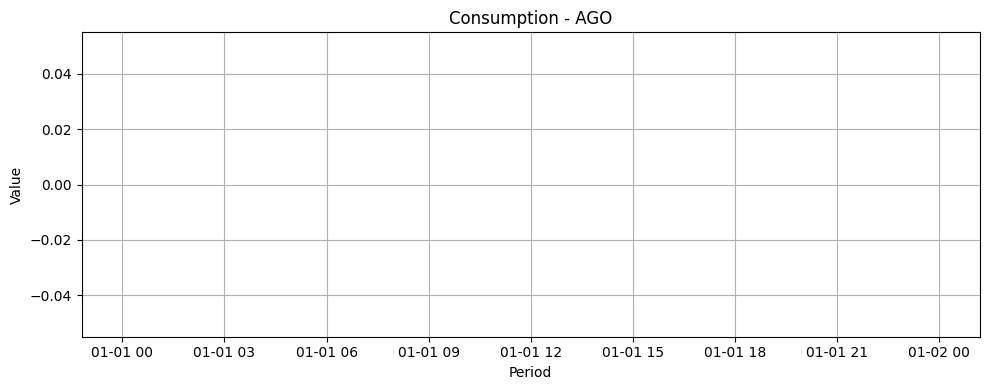

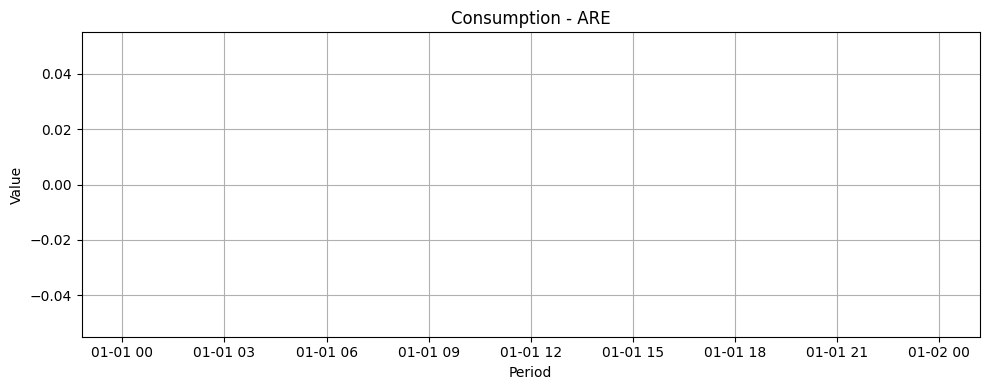

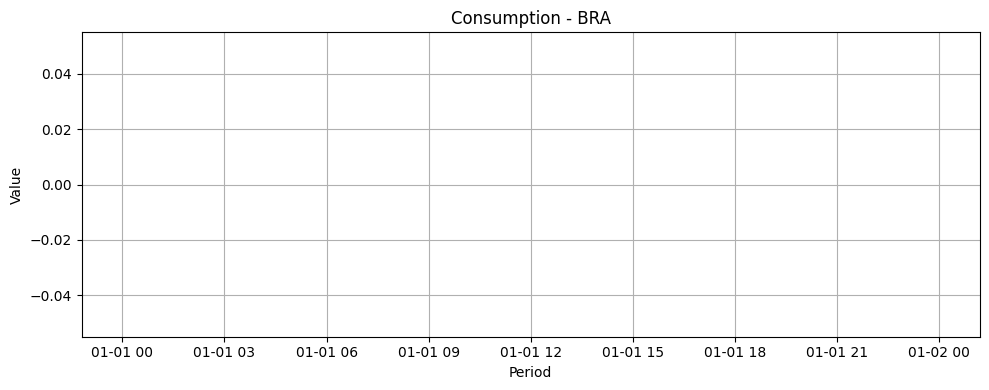

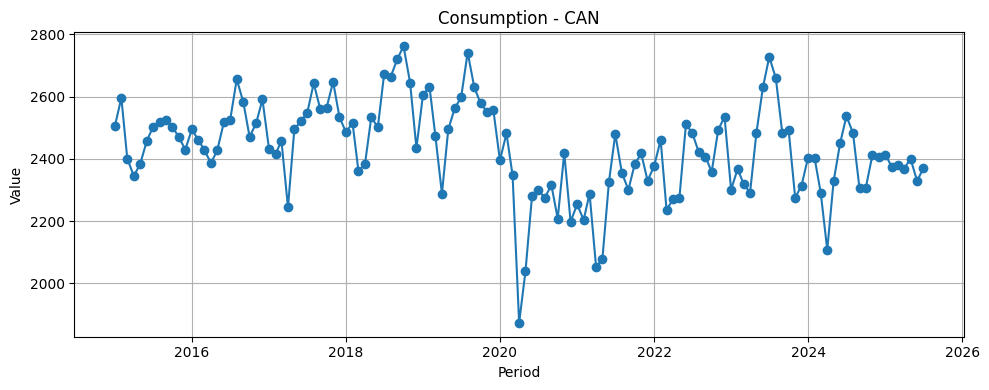

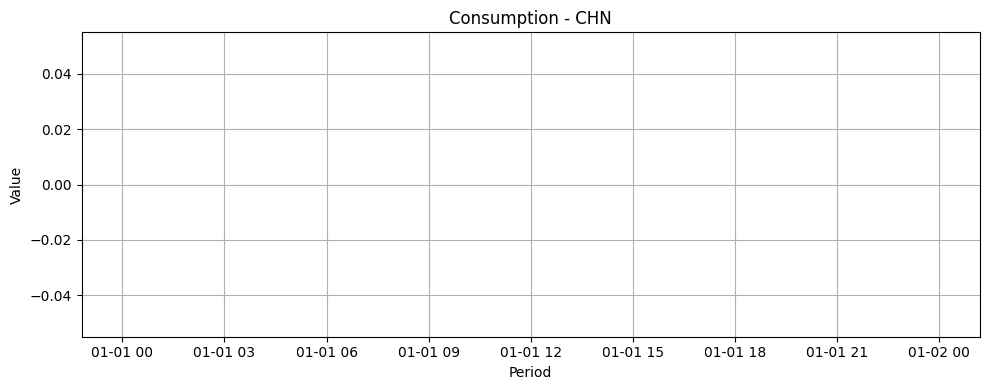

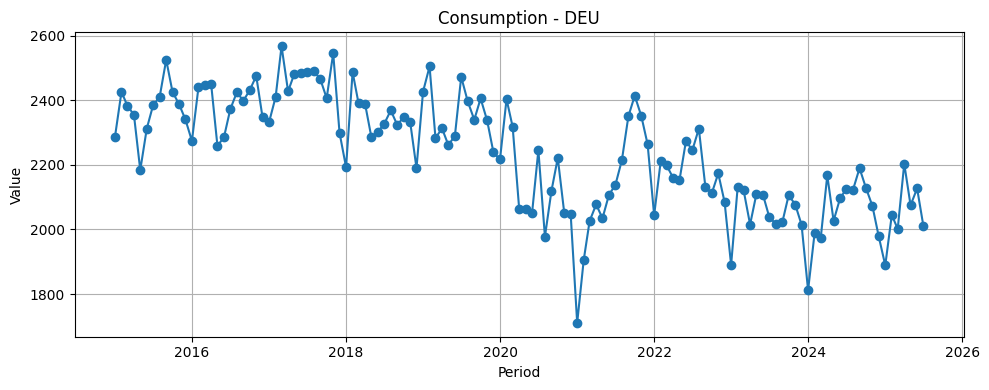

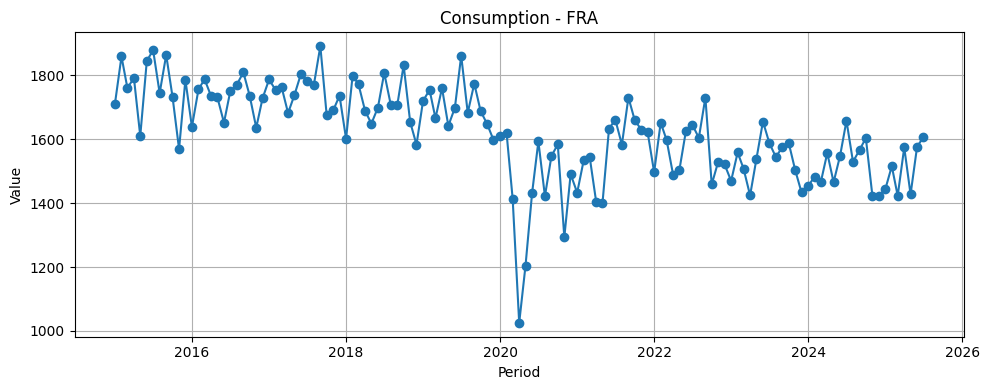

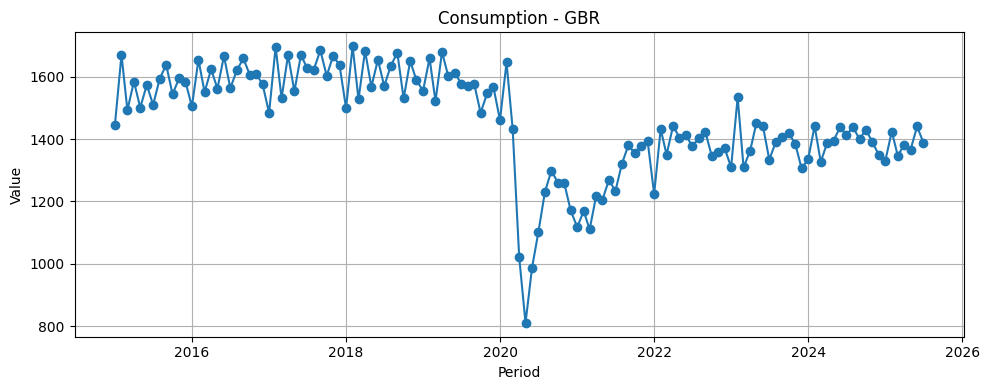

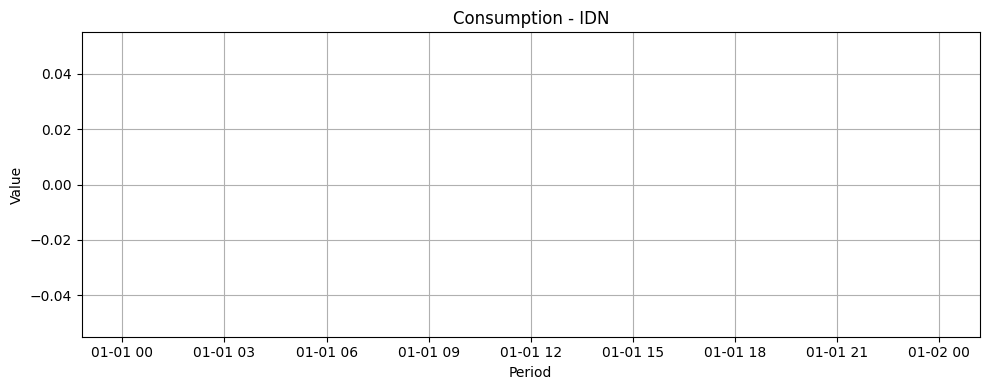

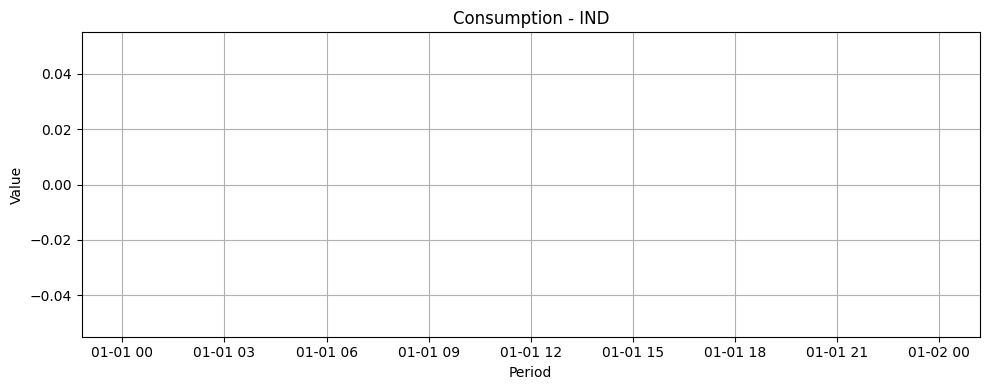

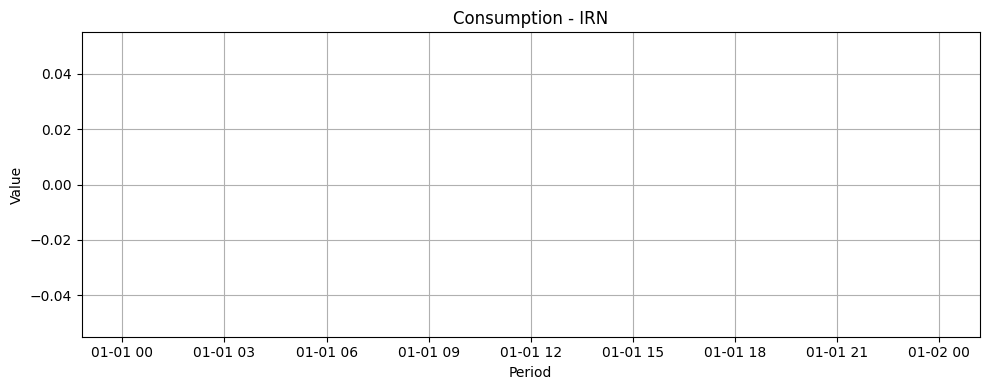

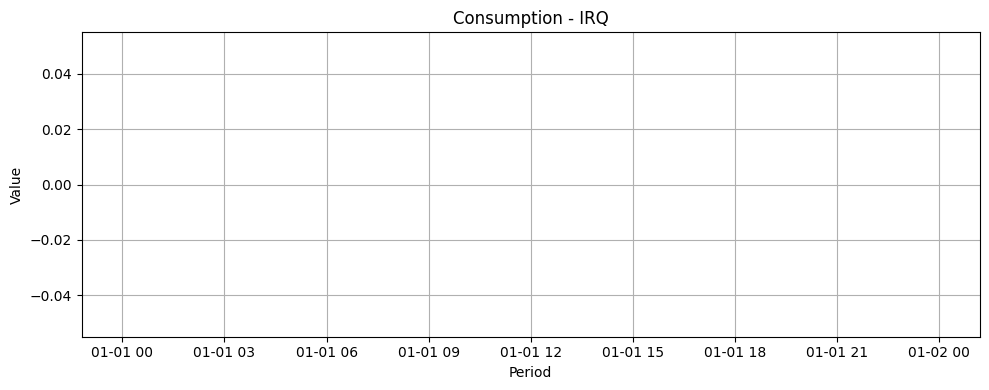

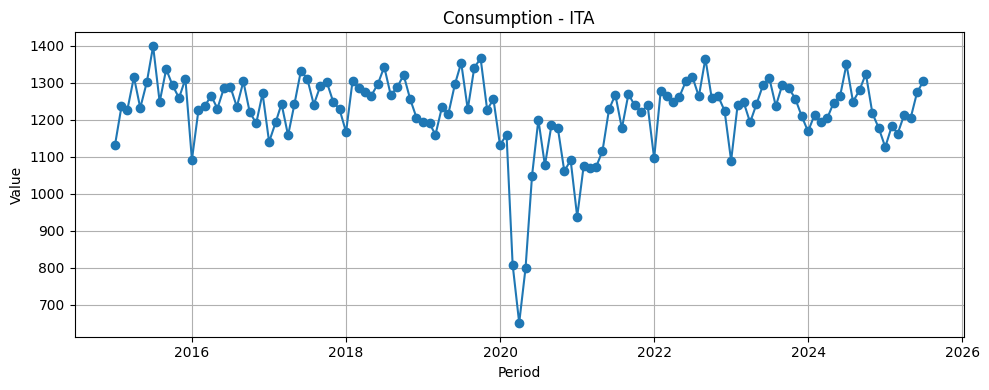

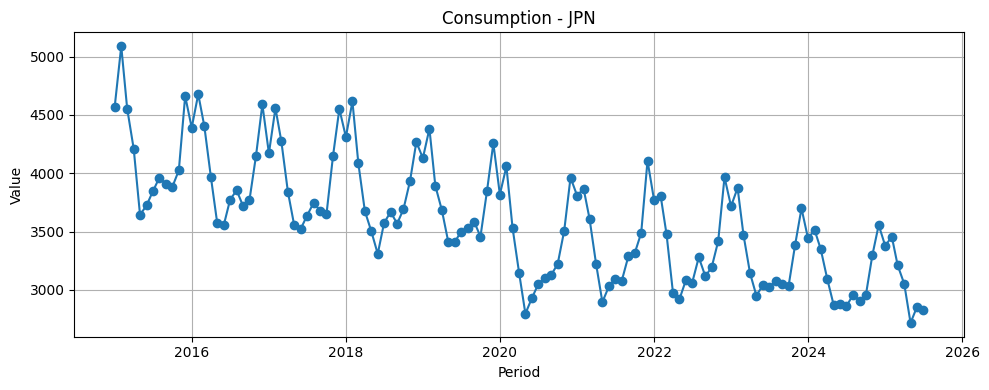

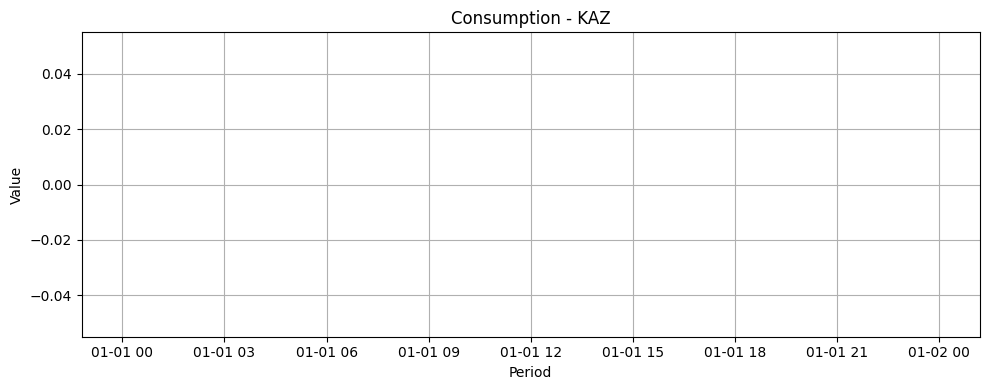

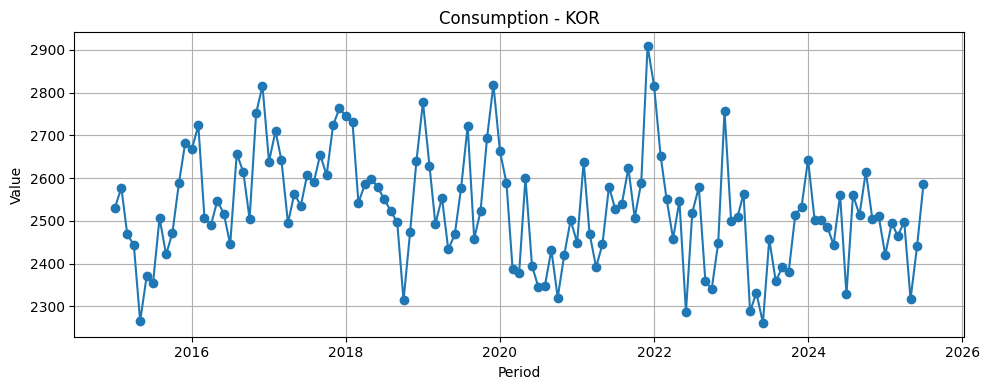

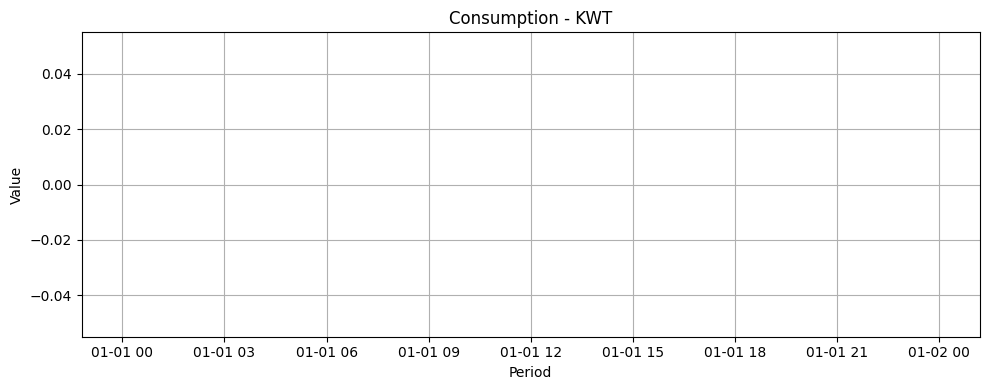

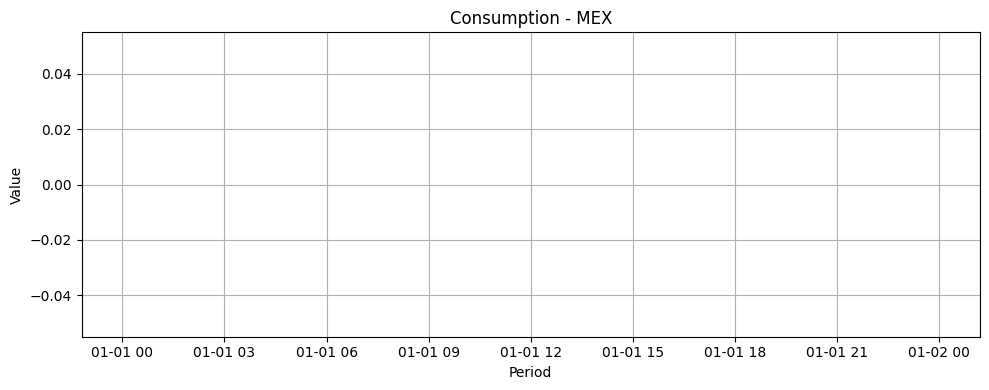

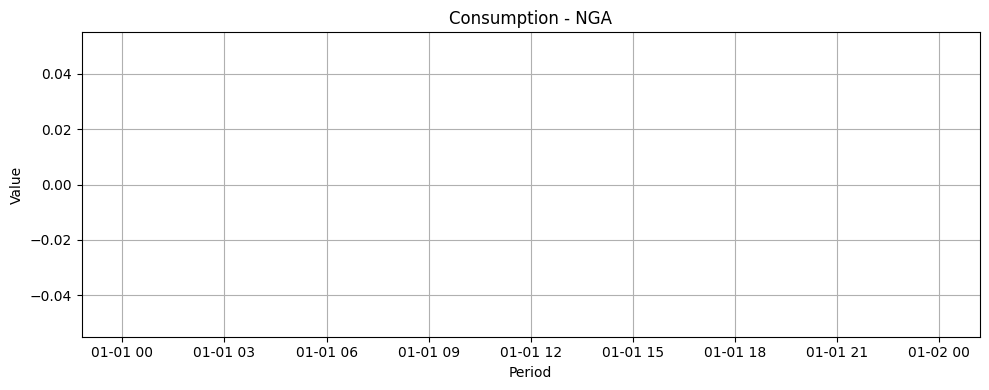

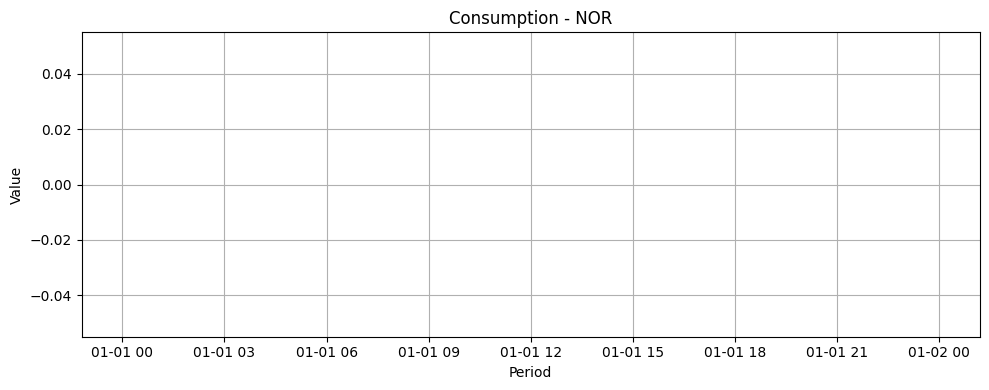

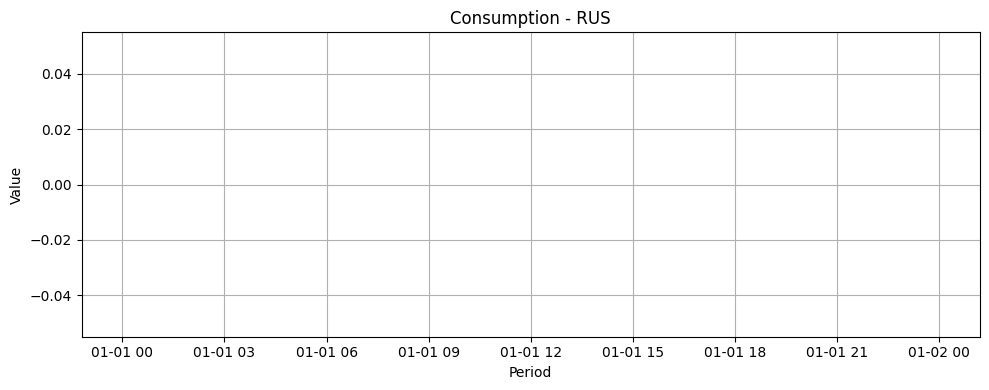

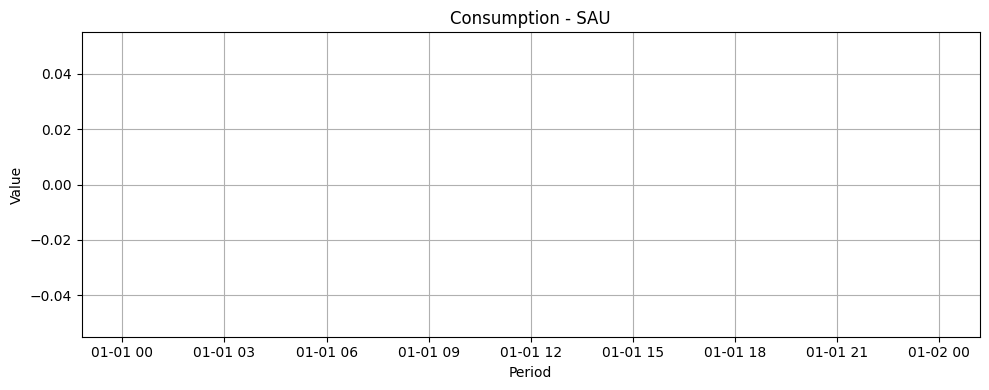

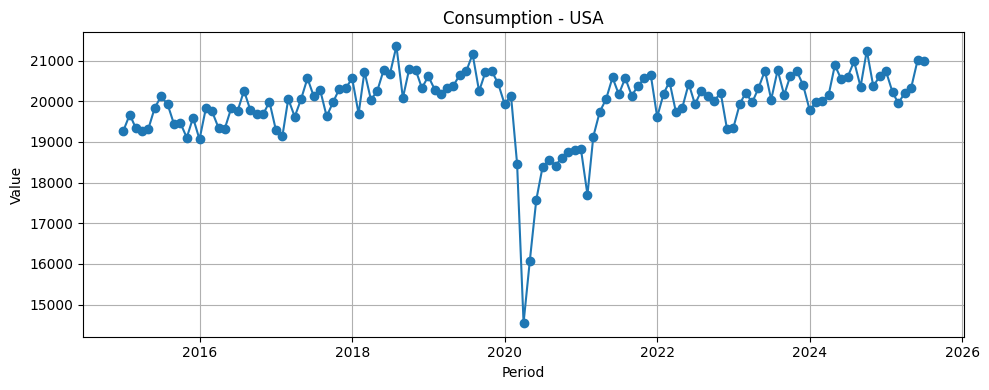

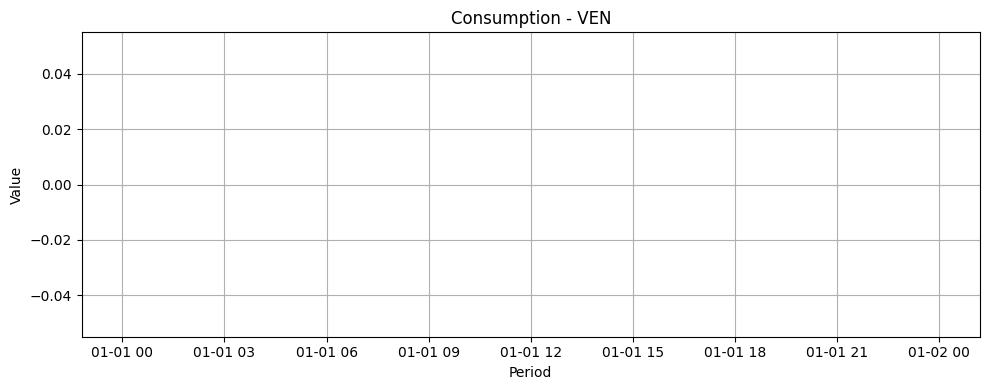

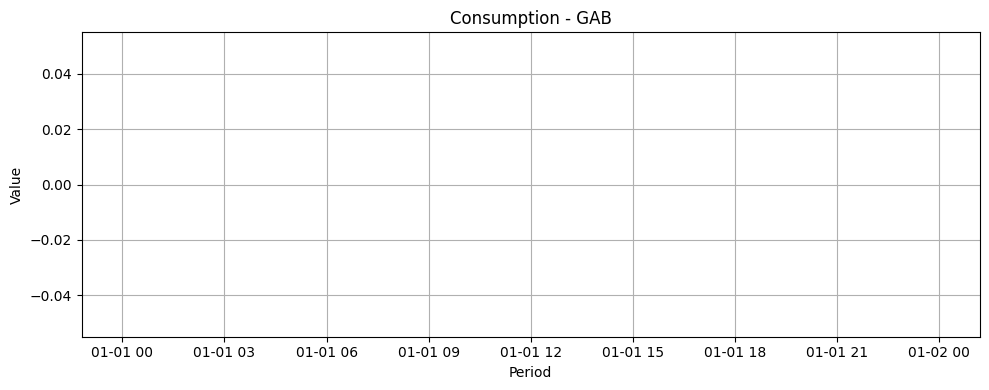

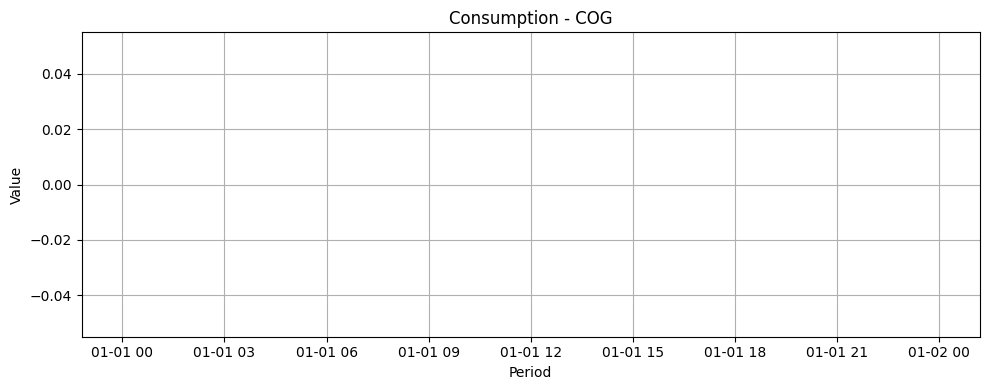

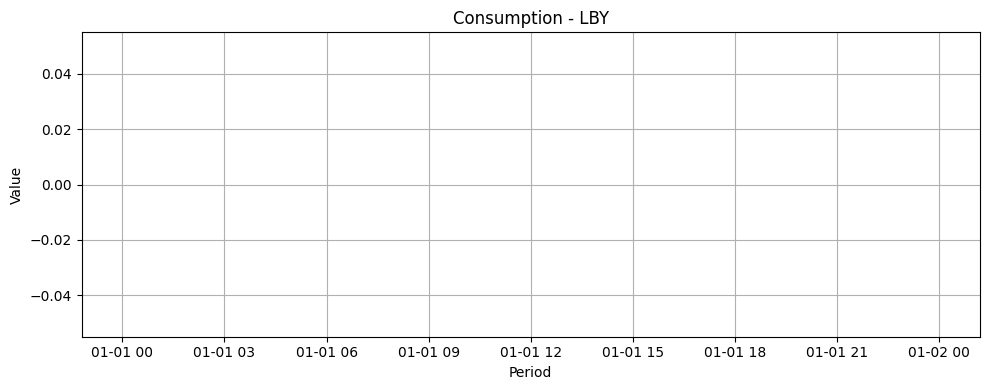

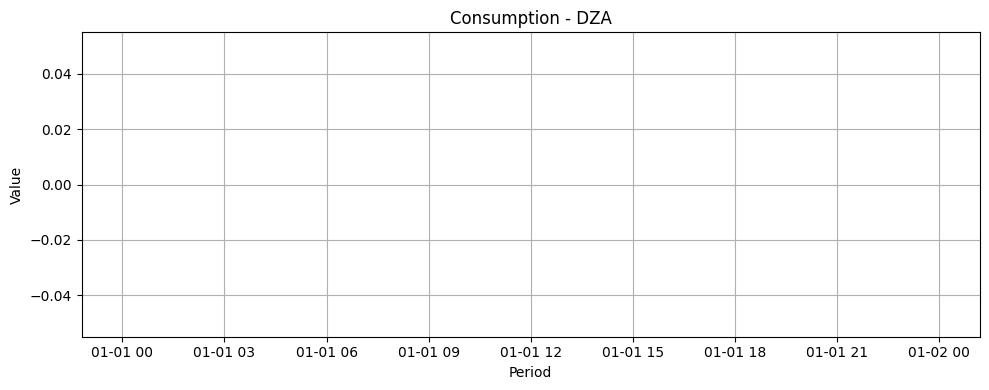

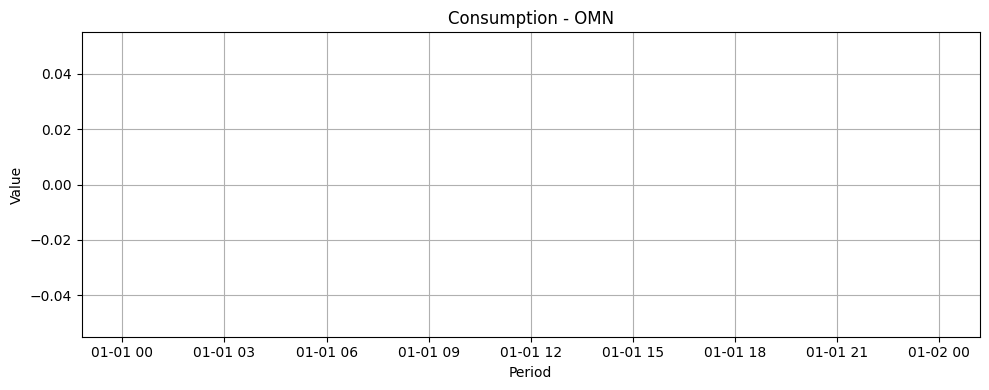

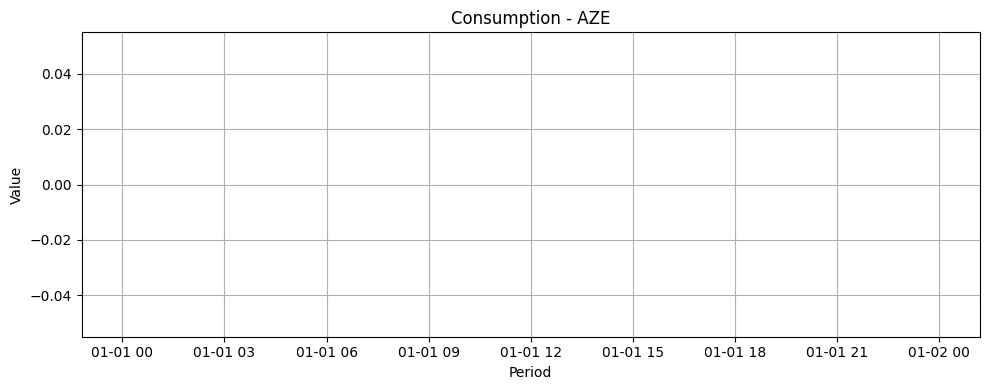

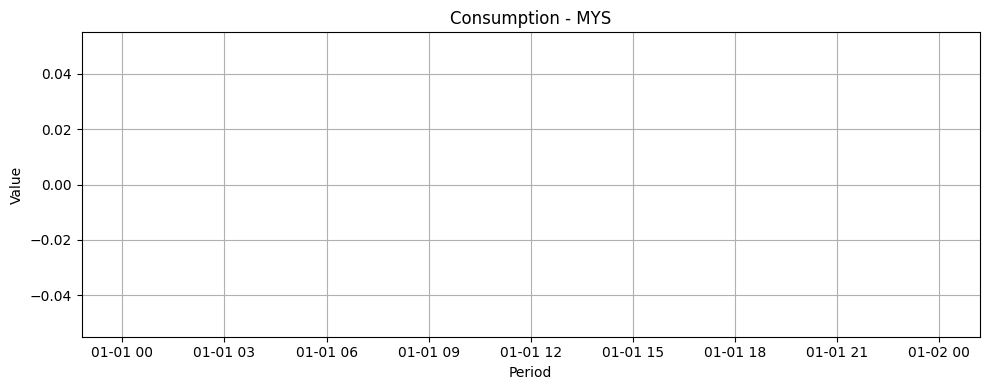

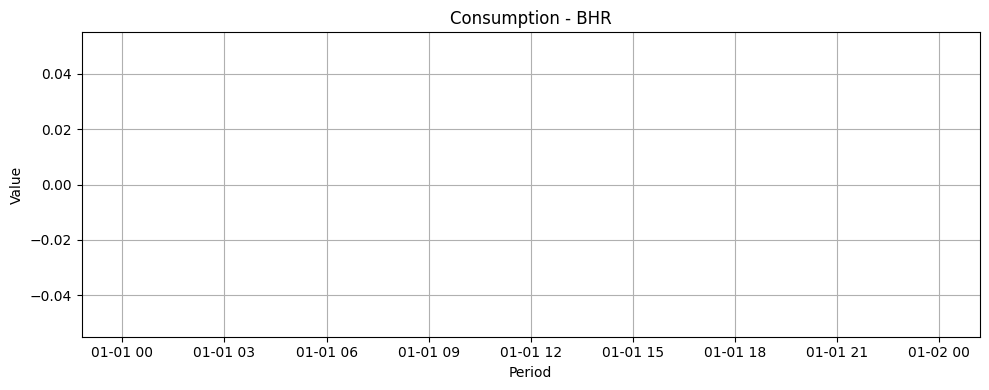

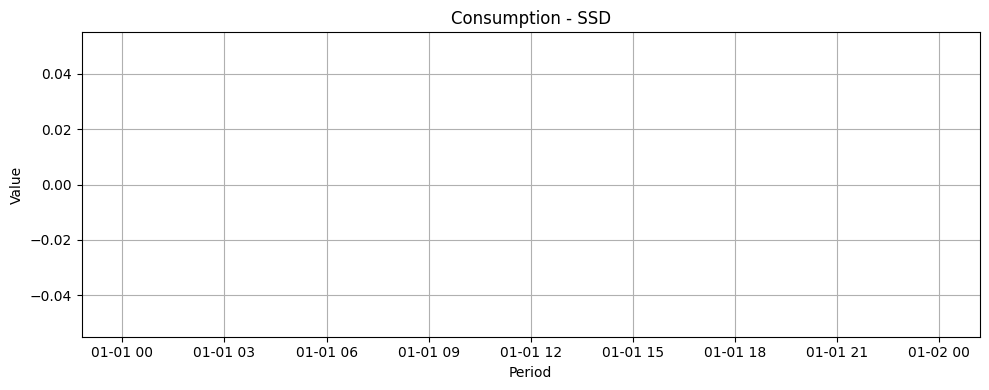

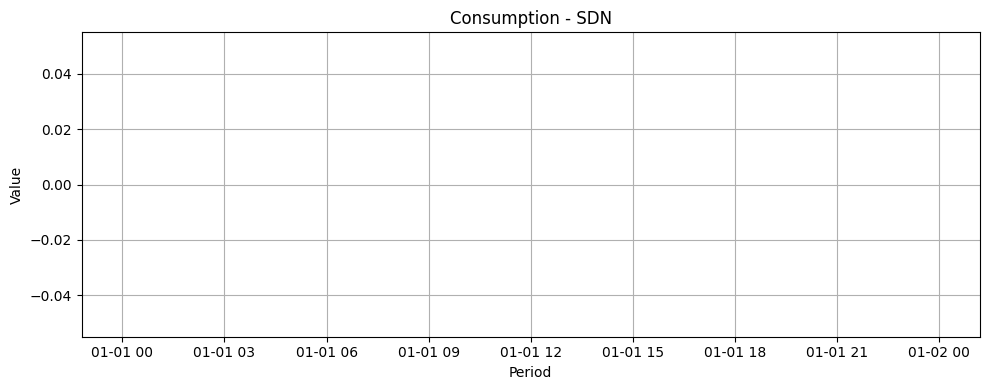

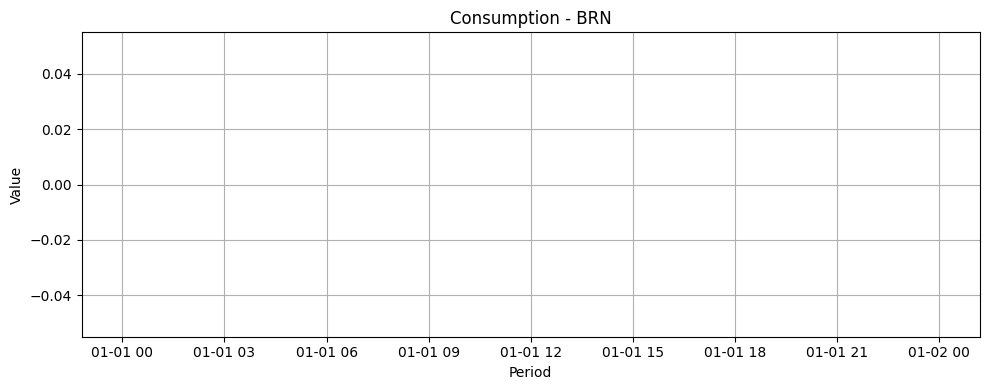

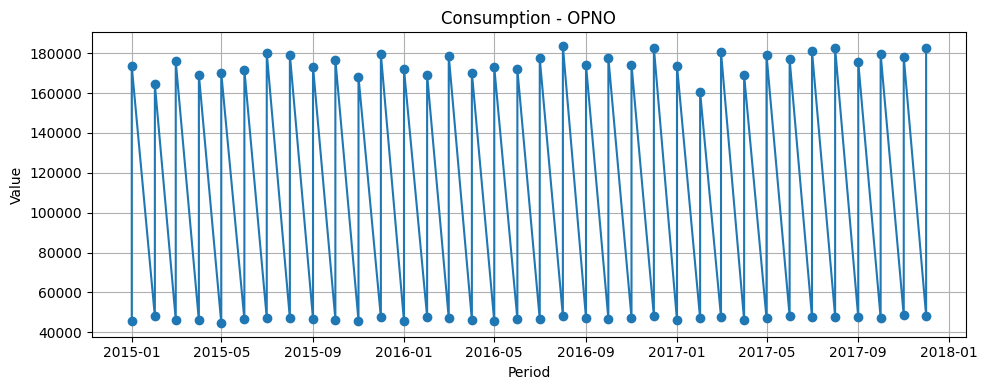

In [80]:
import pandas as pd
from matplotlib import pyplot as plt

# Assume consumption CSV is loaded
consumption = pd.read_csv("data/consumption.csv", parse_dates=["period"])

# Loop over each country / aggregate
for country_id in consumption["countryRegionId"].unique():
    df_country = consumption[consumption["countryRegionId"] == country_id]
    
    plt.figure(figsize=(10, 4))
    plt.plot(df_country["period"], df_country["value"], marker='o', linestyle='-')
    plt.title(f"Consumption - {country_id}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # shows chart for each country


In [78]:
consumption[consumption.countryRegionId == "RUS"]

,period,productName,activityId,activityName,countryRegionId,countryRegionName,value,unit
1671,2022-12-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1672,2022-11-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1673,2022-10-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1674,2022-09-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1675,2022-08-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1676,2022-07-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1677,2022-06-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1678,2022-05-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1679,2022-04-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD
1680,2022-03-01,Refined petroleum products,2,Consumption,RUS,Russia,NaN,TBPD


In [74]:
production.productName.unique()

array(['Total petroleum and other liquids', 'Other liquids', 'NGPL',
       'Crude oil including lease condensate', 'Refinery processing gain',
       'Crude oil, NGPL, and other liquids'], dtype=object)

In [66]:
stocks

,period,productName,activityId,activityName,countryRegionId,countryRegionName,value,unit
0,2025-07-01,Petroleum and other liquids,5,"Stocks, OECD",CAN,Canada,194.053,MBBL
1,2025-06-01,Petroleum and other liquids,5,"Stocks, OECD",CAN,Canada,187.540,MBBL
2,2025-05-01,Petroleum and other liquids,5,"Stocks, OECD",CAN,Canada,184.636,MBBL
3,2025-04-01,Petroleum and other liquids,5,"Stocks, OECD",CAN,Canada,192.766,MBBL
4,2025-03-01,Petroleum and other liquids,5,"Stocks, OECD",CAN,Canada,188.058,MBBL
...,...,...,...,...,...,...,...,...
3065,2000-05-01,Petroleum and other liquids,5,"Stocks, OECD",ITA,Italy,147.537,MBBL
3066,2000-04-01,Petroleum and other liquids,5,"Stocks, OECD",ITA,Italy,151.670,MBBL
3067,2000-03-01,Petroleum and other liquids,5,"Stocks, OECD",ITA,Italy,153.753,MBBL
3068,2000-02-01,Petroleum and other liquids,5,"Stocks, OECD",ITA,Italy,149.280,MBBL
